In [1]:
import os
import numpy as np
from numpy.linalg import eigvalsh
import math
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix, kron
from itertools import product, combinations
plt.rcParams["font.family"] = "Times New Roman"
# Enable LaTeX rendering in Matplotlib
plt.rc('text', usetex=True)
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm


<h3>The goal here is to implement a function that does MDS using the coupling stregth of the approximate 2-local form found for an initial Hamiltonian.<h3>

We start with loading the couplings

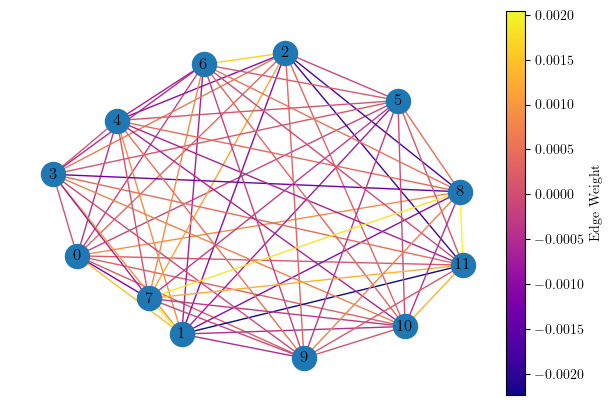

In [2]:
N = 12 # system size
k = 0 # sample number
letters = ['1', 'X', 'Y', 'Z']
a=3
b=3
Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))
#threshold = 1e-4  # Set this to the threshold you want to use
#Jab[np.abs(Jab) < threshold] = 0

def define_graph(Jab):
    # Create a graph from Jab
    G = nx.from_numpy_array(Jab)
    
    edge_colors = [float(e[2]['weight']) for e in G.edges(data=True)]
    cmap = plt.cm.plasma  # You can choose any colormap you prefer

    # Create figure and axes
    fig, ax = plt.subplots()

    # Draw the graph with edge colors based on weight
    nx.draw(G, with_labels=True, edge_cmap=cmap, edge_color=edge_colors, edge_vmin=min(edge_colors), edge_vmax=max(edge_colors), ax=ax)

    # Create colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=min(edge_colors), vmax=max(edge_colors)))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.9, 0.1, 0.03, 0.8])
    fig.colorbar(sm, cax=cbar_ax, label='Edge Weight')
    plt.show()

define_graph(Jab)

We need to work with a weighted graph.

We need a distance function. In the paper by Charles and Carroll they define D(a,b)=min_P(sum_{i} w(p_i,p_{i+1})). Intuitively, look at all paths we can take to go from one vertext to the other and find the one that minimizes the sum of weights along that path.
We cannot work like that since we expect closer points to have larger Jab. So do we just look for the max? Neither, since we could always imagine adding to our path to make it longer. We simply define the distance between 2 points as the value (or a function of that value) of the coupling strength between them. We need to define a function to give us a smaller value for a larger Jab. But it seems that choosing the function will determine the dimension of space no?


In [3]:
def distance(Jab):
    dab=Jab
    eps=1e-6
    for i in range(dab.shape[0]):
        for j in range(dab.shape[1]):
            dab[i][j]=1/(Jab[i][j]+eps)
    return dab

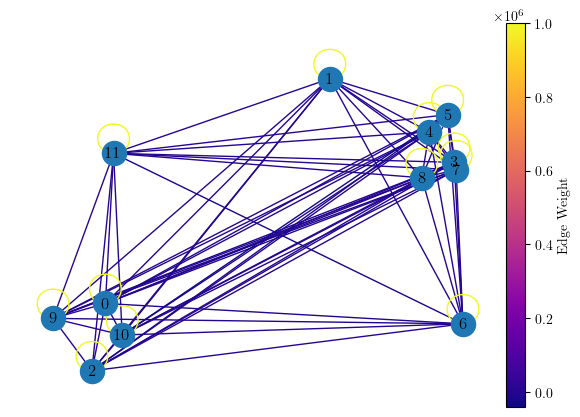

In [4]:
dab=distance(Jab)
define_graph(dab)

We now ask weather this graph with a distance defined on it approximates a smooth manifold of dim D
-There is the ball approach
-There is also the MDS approach which we will pursue.

About MDS: procedure to embedd a graph with distance into a symmetric manifold. We focuse on Euclidean.
To do this we define matrix B as defined in Charles's paper.
$$B_{pq}=-\frac{1}{2}(d(p,q)^2-\frac{1}{N}\sum^{N}_{l=1}d(p,l)^2-\frac{1}{N}\sum^{N}_{l=1}d(l,q)^2+\frac{1}{N^2}\sum^N_{l,m=1}d(l,m)^2)$$

From $B$ we contruct $X$
$$X=(\sqrt{\lambda_1}v_1,...)$$

In [5]:
def calculate_B(dab):
    N = len(dab)
    B = [[0 for _ in range(N)] for _ in range(N)]
    
    for p in range(N):
        for q in range(N):
            if p == q:
                continue
            d_pq = dab[p][q]
            d_p_sum = sum([dab[p][l] for l in range(N) if l != q])
            d_q_sum = sum([dab[l][q] for l in range(N) if l != p])
            d_sum = sum([dab[l][m] for l in range(N) for m in range(N) if l != m and m != p and l != q])
            B[p][q] = -0.5 * (d_pq**2 - (d_p_sum + d_q_sum) / N + d_sum / (N**2))

    return B

def calculate_X(B):
    N = np.shape(B)[0]
    X = np.zeros((N, N))

    eigenvalues, eigenvectors = np.linalg.eig(B)
    # Sort eigenvalues and eigenvectors in descending order #TODO should there be something to make negative eigenvalues positive before taking an sqrt?
    eigenvalues=abs(eigenvalues)
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    eigenvectors = eigenvectors[:, idx]

    for i in range(N):
        X[:, i] = np.sqrt(eigenvalues[i]) * eigenvectors[:, i]

    return X

def eigenvalues(B):
    eigenvalues, _ = np.linalg.eig(B)
    eigenvalues=abs(eigenvalues)
    # Sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[idx]
    return eigenvalues


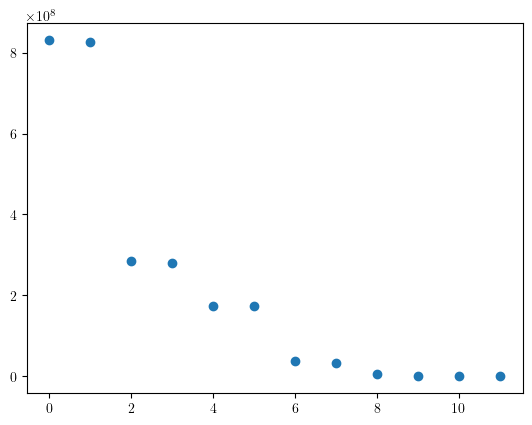

In [6]:
Bab=calculate_B(dab)
eig=eigenvalues(Bab)
Xab=calculate_X(Bab)
plt.scatter(range(len(eig)),eig)

X is our coordinate matrix, we use it to calculate euclidean distances

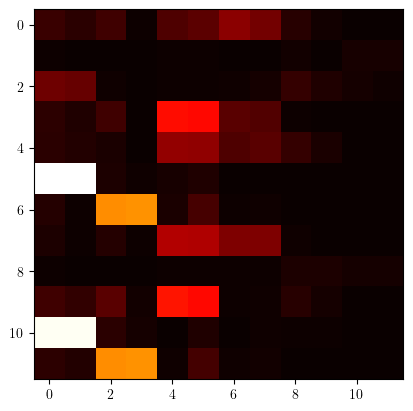

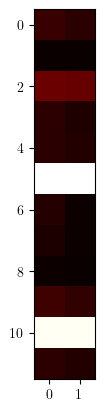

In [17]:
def get_X_D(X,D):
    #We defined here X but only with the first D columns.
    N=np.shape(X)[0]
    if D > N:
        raise ValueError("D exceeds the number of columns in X.")

    X_D = X[:, :D]

    return X_D

X_D=get_X_D(Xab,2)
plt.imshow(abs(Xab), cmap='hot', interpolation='nearest')
plt.show()
plt.imshow(abs(X_D), cmap='hot', interpolation='nearest')
plt.show()


define the euclidean distance function that takes X a coordinate matrix and defines a distance table $d(p,q)=\sum^D_{r=1}(X_{pr}-X_{qr})^2$


In [8]:
print(X_D.shape)

(12, 2)


In [9]:
def euclidean_distance(X):
    N, D = X.shape
    d = np.zeros((N, N))

    for p in range(N):
        for q in range(p+1, N):
            diff = X[p] - X[q]
            d[p, q] = np.sqrt(np.sum(diff**2))
            d[q, p] = d[p, q]

    return d


In [10]:
d_euc=euclidean_distance(X_D)
print(d_euc.shape)
print(dab.shape)

(12, 12)
(12, 12)


We can now introduce the stress function, a way to estimate distortion necessary to embedd our graph in our D dim space.
$$stress=\sqrt{\frac{(\sum_{p,q}d(p,q)d_e(p,q))^2}{(\sum_{p,q}d(p,q))^2(\sum_{p,q}d_e(p,q))^2}}$$

Or we can use 
$$\epsilon_D=1-\frac{\sum^D_i\lambda_i}{\sum^N_i\lambda_i}$$

The smaller the better.

In [11]:
def epsilon(D,eig):
    epsilon = 1-np.sum(eig[:D])/np.sum(eig)
    return epsilon

In [12]:
print(epsilon(2,eig))

0.37472350518472797


We also introduce a function to plot our coordinates in 3D space using the euclidean distance. We expect to see an approximate surface as D=2 seemed to work alright

In [19]:
import plotly.graph_objects as go

def plot_3D_points(X):
    X_3=get_X_D(X,3)
    fig = go.Figure(data=go.Scatter3d(x=X_3[:, 0], y=X_3[:, 1], z=X_3[:, 2], mode='markers'))
    fig.update_layout(title='3D Plot of Points', scene=dict(xaxis=dict(title='X-axis'),
                                                         yaxis=dict(title='Y-axis'),
                                                         zaxis=dict(title='Z-axis')))
    fig.show()

In [20]:
plot_3D_points(Xab)

In [14]:
def MDS():
    

SyntaxError: incomplete input (1947426851.py, line 2)

In [ ]:
#Not ok get abck to this...
def define_R(dab):
    num_vertices = dab.shape[0]
    R = np.zeros((num_vertices, num_vertices))
    v_0=0
    for i in range(num_vertices):
        for j in range(num_vertices):
            d_vi_v0 = np.linalg.norm(dab[i] - v_0)
            d_vj_v0 = np.linalg.norm(dab[j] - v_0)
            d_vi_vj = dab[i, j]
            R[i, j] = 0.5 * (d_vi_v0**2 + d_vj_v0**2 - d_vi_vj**2)

    return R

# Usage example

R = define_R(dab)
print(R)


In [ ]:

paulis = [np.eye(2), np.array([[0,1],[1,0]]), 1j*np.array([[0,-1],[1,0]]), np.array([[1,0],[0,-1]])]
paulis_sparse = [coo_matrix(p, dtype='complex128') for p in paulis]

def operator_from_indexes(indexes, dtype='float64'):
    """
    indexes : list of pauli string indexes (eg [0,1,2,0,3])
    return : coo_matrix representing a pauli string (eg 1XY1Z)
    """
    op = paulis_sparse[indexes[0]]
    for i in indexes[1:]:
        op = kron(op, paulis_sparse[i], format='coo')
    if dtype=='float64':
        op = op.real
    return coo_matrix(op, dtype=dtype)


def Hab(Jab, a, b):
    """
    return the hamiltonian corresponding to a particular interraction type, eg XZ:
    sum_ij Jabij sigma_i^b sigma_j^a
    Jab : matrix of couplings
    a: interraction type
    b: interraction type
    """
    N = len(Jab)
    H = np.zeros((2**N, 2**N))
    for i, j in list(combinations(range(N), 2)):
        pauli_indexes = np.zeros(N, dtype=int)
        pauli_indexes[i] = a
        pauli_indexes[j] = b
        tau = operator_from_indexes(pauli_indexes)
        H[tau.row, tau.col] += Jab[i,j]*tau.data
    return H

def H_from_couplings(N, k):
    """
    return a dense hamiltonian from the saved couplings
    N: system size
    k: sample number
    """
    letters = ['1', 'X', 'Y', 'Z']
    H = 0
    for a,b in [(1,3),(1,1),(2,2),(3,3),(3,1)]:
        Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))
        H += Hab(Jab, a, b)
    return H

if __name__ =='__main__':
    N = 12 # system size
    k = 0 # sample number
    H = H_from_couplings(12, 0) # build a hamiltonian from the couplings
    e = eigvalsh(H) # compute its spectrum
    plt.hist(e, bins=50) # plot the density of states (semicircle)
    plt.show()


In [ ]:

def couplings(N, k):
    letters = ['1', 'X', 'Y', 'Z']
    for a,b in [(1,3),(1,1),(2,2),(3,3),(3,1)]:
        Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))
    return H


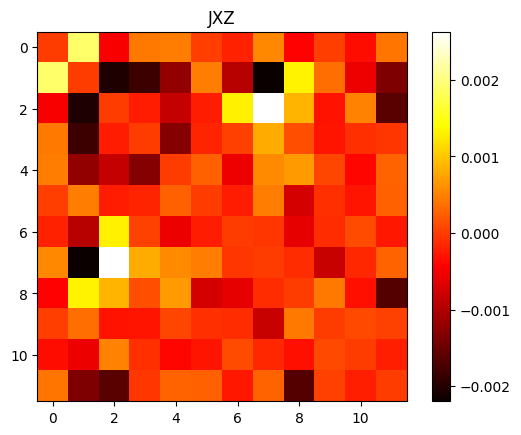

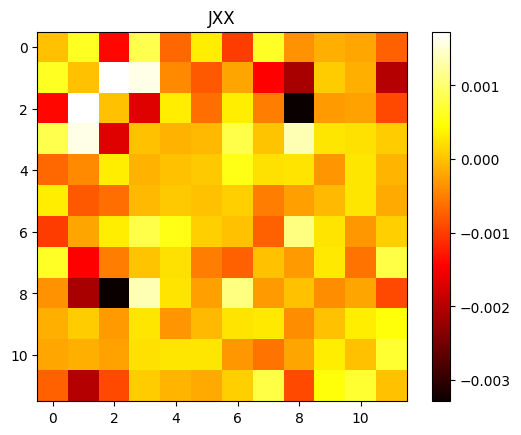

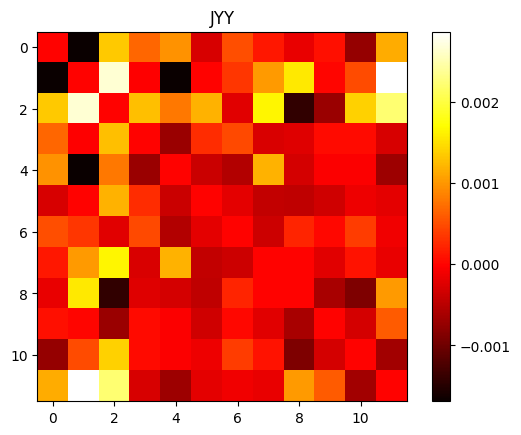

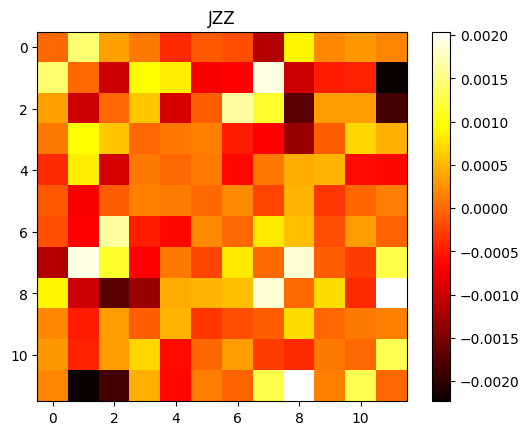

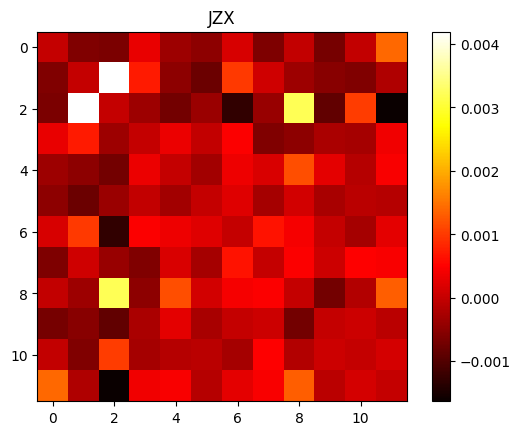

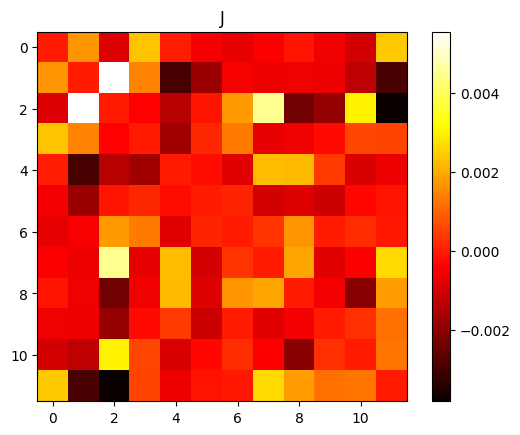

In [ ]:
N = 12 # system size
k = 0 # sample number
letters = ['1', 'X', 'Y', 'Z']
for a,b in [(1,3),(1,1),(2,2),(3,3),(3,1)]:
    Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))
    plt.imshow(Jab, cmap='hot', interpolation='nearest')
    plt.title(f"J{letters[a]}{letters[b]}")
    plt.colorbar()
    plt.show()

J = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[1], letters[3]))
for a,b in [(1,1),(2,2),(3,3),(3,1)]:
    Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))
    J+=Jab
plt.imshow(J, cmap='hot', interpolation='nearest')
plt.title(f"J")
plt.colorbar()
plt.show()

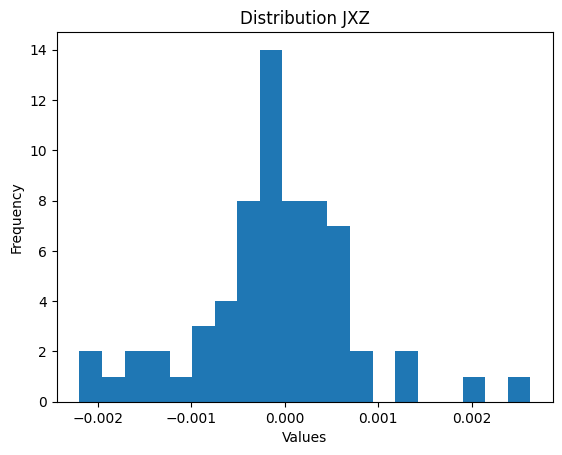

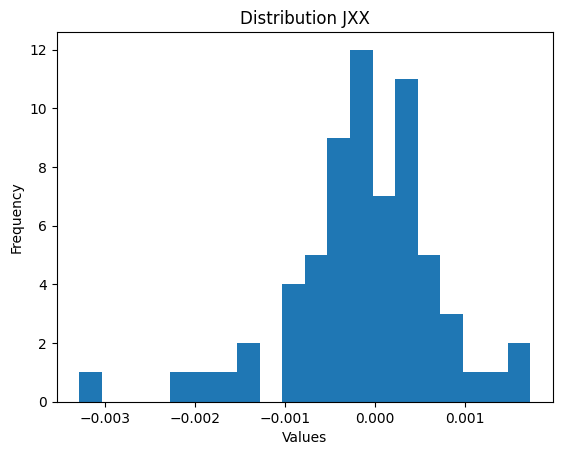

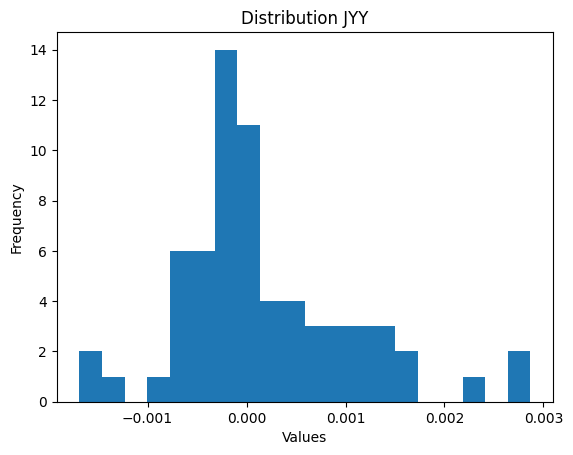

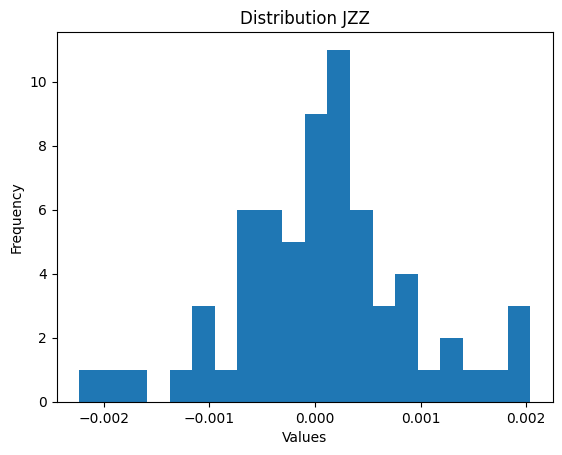

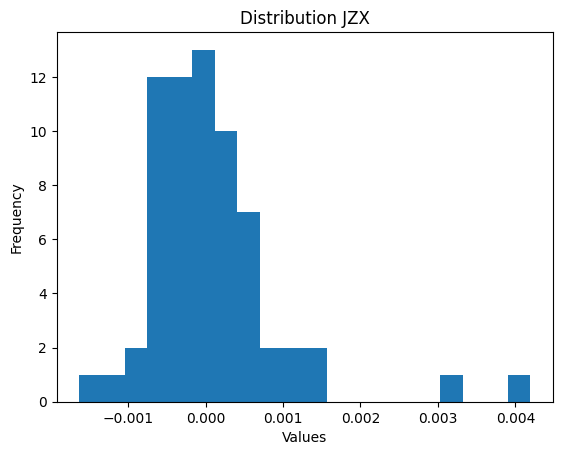

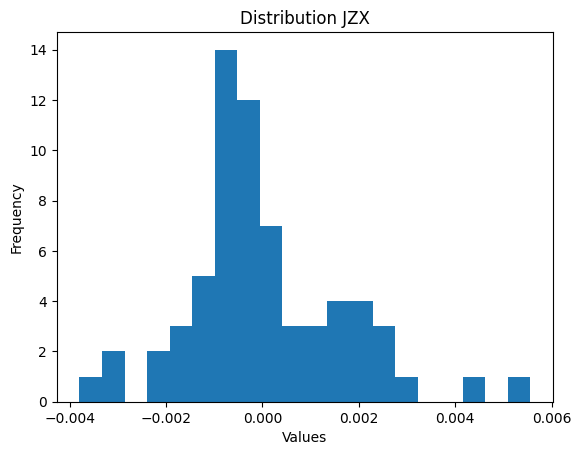

In [ ]:
#Take the top half of the heat matrix and plot the distribution by value...

def plot_Jab_dist(Jab):
    # Get the shape of the matrix
    rows, cols = Jab.shape
    letters = ['1', 'X', 'Y', 'Z']
    # Get the top half of the values into an array
    top_half_values = []
    for i in range(rows):
        for j in range(i+1, cols):
            top_half_values.append(Jab[i][j])
    # Plot a distribution of these values binned by values
    import matplotlib.pyplot as plt

    plt.hist(top_half_values, bins=20)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title(f'Distribution J{letters[a]}{letters[b]}')
    plt.show()

for a,b in [(1,3),(1,1),(2,2),(3,3),(3,1)]:
    Jab = np.loadtxt('couplings/{}/{}_{}{}.txt'.format(N, k, letters[a], letters[b]))
    plot_Jab_dist(Jab)

plot_Jab_dist(J)